# TPHLCT 1階の導関数を相殺する

In [1]:
import numpy as np
import scipy.misc
from scipy.fftpack import dct, idct
import sys
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook as tqdm
from scipy.fftpack import dct, idct
import seaborn as sns
from skimage.metrics import structural_similarity as ssim
import pandas as pd

%matplotlib inline


class ImageLoader:
    def __init__(self, FILE_PATH):
        self.img = np.array(Image.open(FILE_PATH))
        # 行数
        self.row_blocks_count = self.img.shape[0] // 8
        # 列数
        self.col_blocks_count = self.img.shape[1] // 8

    def get_points(self, POINT):
        Row = random.randint(0, len(self.img) - POINT - 1)
        Col = random.randint(0, len(self.img) - 1)
        return self.img[Row : Row + POINT, Col]

    def get_block(self, col, row):
        return self.img[col * 8 : (col + 1) * 8, row * 8 : (row + 1) * 8]


# plt.rcParams['font.family'] ='sans-serif'#使用するフォント
# plt.rcParams["font.sans-serif"] = "Source Han Sans"
plt.rcParams["font.family"] = "Source Han Sans JP"  # 使用するフォント
plt.rcParams["xtick.direction"] = "in"  # x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["ytick.direction"] = "in"  # y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["xtick.major.width"] = 1.0  # x軸主目盛り線の線幅
plt.rcParams["ytick.major.width"] = 1.0  # y軸主目盛り線の線幅
plt.rcParams["font.size"] = 12  # フォントの大きさ
plt.rcParams["axes.linewidth"] = 1.0  # 軸の線幅edge linewidth。囲みの太さ
matplotlib.font_manager._rebuild()

# 画像の用意
MONO_DIR_PATH = "../../Mono/"
OUTPUT_DIR_PATH = "../../Plot_tool/output/images/TPHLCT1/32x32/"
AIRPLANE = ImageLoader(MONO_DIR_PATH + "airplane512.bmp")
BARBARA = ImageLoader(MONO_DIR_PATH + "barbara512.bmp")
BOAT = ImageLoader(MONO_DIR_PATH + "boat512.bmp")
GOLDHILL = ImageLoader(MONO_DIR_PATH + "goldhill512.bmp")
LENNA = ImageLoader(MONO_DIR_PATH + "lenna512.bmp")
MANDRILL = ImageLoader(MONO_DIR_PATH + "mandrill512.bmp")
MILKDROP = ImageLoader(MONO_DIR_PATH + "milkdrop512.bmp")
SAILBOAT = ImageLoader(MONO_DIR_PATH + "sailboat512.bmp")

Images = np.array(
    [
        AIRPLANE,
        BARBARA,
        BOAT,
        GOLDHILL,
        LENNA,
        MANDRILL,
        MILKDROP,
        SAILBOAT
    ]
)

N = 32

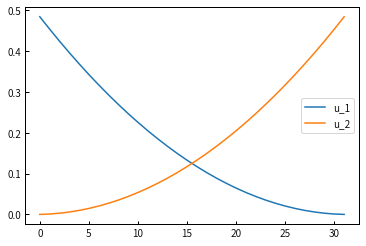

In [2]:
sampling_x = (0.5 + np.arange(N)) / N
u_1 = (1 - sampling_x) ** 2 / 2
u_2 = (sampling_x) ** 2 / 2
plt.plot(u_1, label="u_1")
plt.plot(u_2, label="u_2")
plt.legend()

In [3]:
alpha = -scipy.fftpack.dct(u_1,norm="ortho")
alpha

array([-9.42578864e-01, -8.10243674e-01, -2.02315746e-01, -8.97352733e-02,
       -5.03306486e-02, -3.20903214e-02, -2.21802622e-02, -1.62029774e-02,
       -1.23215704e-02, -9.65848827e-03, -7.75151710e-03, -6.33840654e-03,
       -5.26136563e-03, -4.42082807e-03, -3.75144214e-03, -3.20886401e-03,
       -2.76213586e-03, -2.38910402e-03, -2.07356609e-03, -1.80343954e-03,
       -1.56955394e-03, -1.36483505e-03, -1.18374180e-03, -1.02186977e-03,
       -8.75667049e-04, -7.42226865e-04, -6.19133680e-04, -5.04346991e-04,
       -3.96111897e-04, -2.92888805e-04, -1.93296799e-04, -9.60665949e-05])

In [4]:
beta = scipy.fftpack.dct(u_2,norm="ortho") 
beta

array([ 9.42578864e-01, -8.10243674e-01,  2.02315746e-01, -8.97352733e-02,
        5.03306486e-02, -3.20903214e-02,  2.21802622e-02, -1.62029774e-02,
        1.23215704e-02, -9.65848827e-03,  7.75151710e-03, -6.33840654e-03,
        5.26136563e-03, -4.42082807e-03,  3.75144214e-03, -3.20886401e-03,
        2.76213586e-03, -2.38910402e-03,  2.07356609e-03, -1.80343954e-03,
        1.56955394e-03, -1.36483505e-03,  1.18374180e-03, -1.02186977e-03,
        8.75667049e-04, -7.42226865e-04,  6.19133680e-04, -5.04346991e-04,
        3.96111897e-04, -2.92888805e-04,  1.93296799e-04, -9.60665949e-05])

# DCTして残差を計算

$
V_k = F_k - U_k\\
V_k = F_k -\alpha f_x(0) -\beta f_x(1)\\
f_x(0) \simeq \frac{F_0}{\sqrt{N}}-\frac{F_0^L}{\sqrt{N}}\\
f_x(1) \simeq \frac{F_0^R}{\sqrt{N}}-\frac{F_0}{\sqrt{N}}\\
V_k = F_k - \frac{\alpha}{\sqrt{N}}(F_0^R-F_0)-\frac{\beta_k}{\sqrt{N}}(F_0-F_0^L)
$

## DCT

2次元入力信号を垂直方向の一次元信号が水平方向に並列に並んでいるものとみなし、各列において8画素単位の1次元DCTを適用する

# 量子化テーブル

In [5]:
Q50_Luminance = np.array(
    [
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99],
    ]
)

In [6]:
option = str(N) + "x" + str(N)
img_name = ["Airplane","Barbara","Boat","Goldhill","Lenna","Mandrill","Milkdrop","Sailboat"]
df = pd.read_excel("../../Plot_tool/xlsx/TPHLCT1_"+ option +".xlsx",sheet_name=None)

for i in range(len(Images)):
    name = img_name[i]
    IMG = Images[i]
    df_Q = df[name]["Q"]

    for j in range(13):
        bpp = 0.2 + 0.05 * j
        Q = df_Q[j]
        
        Fk = np.zeros(IMG.img.shape)
        # 順変換
        # 縦方向
        for row in range(IMG.img.shape[0] // N):
            for col in range(IMG.img.shape[1]):
                eight_points = IMG.img[N * row : N * (row + 1), col]
                c = scipy.fftpack.dct(eight_points,norm="ortho")
                Fk[N * row : N * (row + 1), col] = c
                
        for row in range(Fk.shape[0] // N):
            for col in range(Fk.shape[1]):
                F = Fk[N * row : N * (row + 1), col]

                F_0_r = 0
                if row is not Fk.shape[0] // N - 1:
                    F_0_r = Fk[N * (row + 1), col]

                F_0_l = 0
                if row is not 0:
                    F_0_l = Fk[N * (row - 1), col]

                # 残差
                F_0 = F[0]
                F = F - alpha * (F_0_r - F_0) / np.sqrt(N) - beta * (F_0 - F_0_l) / np.sqrt(N)
                # F_0は残す
                F[0] = F_0
                # F_0 V_1 V_2 V_3 V_4 V_5 V_6 V_7
                Fk[N * row : N * (row + 1), col] = F
                
        # 横方向
        for row in range(Fk.shape[0]):
            for col in range(Fk.shape[1] // N):
                eight_points = Fk[row, N * col : N * (col + 1)]
                c = scipy.fftpack.dct(eight_points,norm="ortho")
                Fk[row, N * col : N * (col + 1)] = c
                
        for row in range(Fk.shape[0]):
            for col in range(Fk.shape[1] // N):
                F = Fk[row, N * col : N * (col + 1)]

                F_0_r = 0
                if col is not Fk.shape[1] // N - 1:
                    F_0_r = Fk[row, N * (col + 1)]

                F_0_l = 0
                if col is not 0:
                    F_0_l = Fk[row, N * (col - 1)]

                # 残差
                F_0 = F[0]
                F = F - alpha * (F_0_r - F_0) / np.sqrt(N) - beta * (F_0 - F_0_l) / np.sqrt(N)
                # F_0は残す
                F[0] = F_0
                # F_0 V_1 V_2 V_3 V_4 V_5 V_6 V_7
                Fk[row, N * col : N * (col + 1)] = F
        
        Fk_Ori = np.copy(Fk)
        
#         if Q < 50:
#             S = 5000 / Q
#         else:
#             S = 200 - 2 * Q

#         S = np.floor(S)

#         Q_Luminance = np.zeros((N, N))
#         for row in range(N):
#             for col in range(N):
#                 Q_Luminance[row, col] = np.floor((S * Q50_Luminance[row, col] + 50) / 100)
        
        Fk = np.copy(Fk_Ori)
        Q_Fk = np.zeros(Fk.shape)
        
        Q_Luminance = np.ones((N,N)) * Q
        
        # 量子化
        for row in range(IMG.img.shape[0] // N):
            for col in range(IMG.img.shape[1] // N):
                block = Fk[row * N : (row + 1) * N, col * N : (col + 1) * N]
                # 量子化
                block = np.round(block / Q_Luminance)
                # 逆量子化
                block = block * Q_Luminance
                Q_Fk[row * N : (row+1)*N, col * N : (col+1)*N] = block     
        
        # 逆変換
        # 横方向
        Fk = np.copy(Q_Fk)
        Q_recover = np.zeros(Q_Fk.shape)
        for row in range(Fk.shape[0]):
            for col in range(Fk.shape[1] // N):
                F = Fk[row, N * col : N * col + N]

                F_0_r = 0
                if col is not Fk.shape[1] // N - 1:
                    F_0_r = Fk[row, N * (col + 1)]

                F_0_l = 0
                if col is not 0:
                    F_0_l = Fk[row, N * (col - 1)]

                # 残差
                F_0 = F[0]
                F = F + alpha * (F_0_r - F_0) / np.sqrt(N) + beta * (F_0 - F_0_l) / np.sqrt(N)
                # F_0は残す
                F[0] = F_0
                # F_0 V_1 V_2 V_3 V_4 V_5 V_6 V_7
                Fk[row, N * col : N * col + N] = F
                
        for row in range(Fk.shape[0]):
            for col in range(Fk.shape[1] // N):
                F = Fk[row, N * col : N * col + N]
                data = scipy.fftpack.idct(F,norm="ortho")
                # Fkに代入した後、縦方向に対して処理
                Fk[row, N * col : N * col + N] = data
        
        # 縦方向
        for row in range(Fk.shape[0] // N):
            for col in range(Fk.shape[1]):
                F = Fk[N * row : N * row + N, col]

                F_0_r = 0
                if row is not Fk.shape[0] // N - 1:
                    F_0_r = Fk[N * (row + 1), col]

                F_0_l = 0
                if row is not 0:
                    F_0_l = Fk[N * (row - 1), col]

                # 残差
                F_0 = F[0]
                F = F + alpha * (F_0_r - F_0) / np.sqrt(N) + beta * (F_0 - F_0_l) / np.sqrt(N)
                # F_0は残す
                F[0] = F_0
                # F_0 F_1 F_2 F_3 F_4 F_5 F_6 F_7
                Fk[N * row : N * row + N, col] = F
                
        for row in range(Fk.shape[0] // N):
            for col in range(Fk.shape[1]):
                F = Fk[N * row : N * (row + 1), col]
                data = scipy.fftpack.idct(F,norm="ortho")
                # 復元画像
                Q_recover[N * row : N * (row + 1), col] = data
                
        Q_recover = np.round(Q_recover)
        plt.imsave(OUTPUT_DIR_PATH + "TPHLCT1_" + option + "_" + name + "_" + "{:.2f}".format(bpp) + ".png",Q_recover,cmap="gray")